In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
from bs4 import BeautifulSoup
import time
import seaborn as sns
import folium


In [2]:
data = pd.read_csv('houses_current.csv')
data.head()
len(data)

9674

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9674 entries, 0 to 9673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseTypes  9674 non-null   object 
 1   area        9497 non-null   float64
 2   num_floors  7706 non-null   float64
 3   bedrooms    7577 non-null   float64
 4   address     9674 non-null   object 
 5   price       9548 non-null   float64
 6   url         9674 non-null   object 
dtypes: float64(4), object(3)
memory usage: 529.2+ KB


REMOVE DUPLICATES

In [4]:
print('Sum of duplicates: ', data.duplicated(subset=['houseTypes', 'area', 'num_floors', 'bedrooms','address','price']).sum())
data = data.drop_duplicates(subset=['houseTypes', 'area', 'num_floors', 'bedrooms','address','price']).copy()
print('After removing duplicates: ', data.duplicated().sum())
print('Length of data then: ', len(data))

Sum of duplicates:  1066
After removing duplicates:  0
Length of data then:  8608


CONVERT OBJECT TO FLOAT64 AND STRING

In [5]:
data = data.astype({'houseTypes':'string','address':'string','url':'string'})

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8608 entries, 0 to 9673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseTypes  8608 non-null   string 
 1   area        8447 non-null   float64
 2   num_floors  6798 non-null   float64
 3   bedrooms    6698 non-null   float64
 4   address     8608 non-null   string 
 5   price       8492 non-null   float64
 6   url         8608 non-null   string 
dtypes: float64(4), string(3)
memory usage: 538.0 KB


In [7]:
for col in data.columns:
    print('Ratio of missing data of ' + str(col) +': ' + str(round(data[col].isna().sum()*100/len(data[col]),3)) + '%')

Ratio of missing data of houseTypes: 0.0%
Ratio of missing data of area: 1.87%
Ratio of missing data of num_floors: 21.027%
Ratio of missing data of bedrooms: 22.189%
Ratio of missing data of address: 0.0%
Ratio of missing data of price: 1.348%
Ratio of missing data of url: 0.0%


In [8]:
data[['district','city']] = data['address'].apply(lambda x: pd.Series(str(x).split(', ')))

In [40]:
data = data.drop(['address'], axis=True)

In [9]:
data.reset_index(inplace=True, drop=True)

In [10]:
data = data[['houseTypes','area','num_floors','bedrooms','district','city','price','url']]

In [11]:
data.head()

,houseTypes,area,num_floors,bedrooms,district,city,price,url
0,Bán Nhà riêng,130.0,3.0,7.0,Quận 12,TP Hồ Chí Minh,9.200,https://batdongsan.vn/ban-biet-thu-san-vuon-qu...
1,Bán Nhà riêng,65.0,NaN,2.0,Ngũ Hành Sơn,Đà Nẵng,2.900,https://batdongsan.vn/29-ty-dien-tich-6580m2-n...
2,Bán Nhà riêng,90.0,5.0,5.0,Hai Bà Trưng,Hà Nội,14.000,https://batdongsan.vn/ban-nha-kim-nguu-phan-lo...
3,Bán Nhà riêng,50.0,5.0,5.0,Quận 3,TP Hồ Chí Minh,0.001,https://batdongsan.vn/quan-3-le-van-sy-5-tang-...
4,Bán Nhà riêng,30.0,1.0,2.0,Gò Vấp,TP Hồ Chí Minh,3.700,https://batdongsan.vn/nha-moi-full-noi-that-hx...


In [12]:
# data.to_csv('houses.csv',index=False)
# data.to_excel('houses.xlsx',index=False)

In [13]:
low_noise_data = data.loc[(data['price'] < 0.1)]
hign_noise_data = data.loc[(data['price'] >= 500)]
null_price_data = data[data['price'].isna()]


In [14]:
low_noise_data = low_noise_data.copy()
low_noise_data.to_excel('error_price_low.xlsx', index=False)  

In [46]:
hign_noise_data = hign_noise_data.copy()
hign_noise_data.to_excel('error_price_hign.xlsx', index=False)  

In [53]:
# new_low_price = []
# for url in low_noise_data['url']:
#     match = re.search(r'(\d+)-ty', url) or re.search(r'(\d+)ty-', url) or re.search(r'(\d+)-ti', url)
#     if match:
#         number = match.group(1)
#         if int(number) <= 10:
#             new_low_price.append(float(number))
#         elif int(number) <= 100:
#             new_low_price.append(float(number)/10)
#         else:
#             new_low_price.append(float(number)/100)
#     else:
#         match = re.search(r'(\d+)-trieu-', url) or re.search(r'(\d+)tr-', url) or re.search(r'(\d+)trieu-', url)
#         if match:
#             number = match.group(1)
#             new_low_price.append(float(number)/1000)
#         else:
#             new_low_price.append(0)
  
# -2ty5-    -70trm2-    -2x-ty-  -4ty95-    -2ty2x-     -shr6ty120-  -360trphan             

In [54]:
# new_price =[]
# count_error = 0
# for url in low_noise_data['url']:
#     match = re.search(r'(\d+)-ty', url) 
#     if match:
#         number = match.group(1)
#         if int(number) > 10 & int(number) < 100:
#             new_price.append(float(number)/10)
#         elif int(number) >= 100:
#             new_price.append(float(number)/100)
#         else:
#             new_price.append(float(number))
#     else:
#         match =  re.search(r'(\d+)tr', url)
#         if match:
#             new_price.append(float(match.group(1))/1000)
#         elif match == None:
#             try:
#                 data = requests.get(url)
#                 soup = BeautifulSoup(data.text, 'lxml')
#                 if data:
#                     if(soup.find('div',{'class':'project-global-object-block-003 information-custom'}) and soup.find('div',{'class':'content'})):
#                         text_info=""
#                         text_info = soup.find('div',{'class':'project-global-object-block-003 information-custom'}).text.strip() + soup.find('div',{'class':'content'}).text.strip().replace('\n','')
#                         text_info = text_info.replace("\r"," ")
#                         text_info = text_info.replace("\n"," ")
#                         text_info = text_info.replace("\t"," ")
#                         z = re.search(r"(\d+(?:\.\d+)?(?:,\d+)?) Tỷ", text_info, re.IGNORECASE)
#                         if z:
#                             new_price.append(float(z.group(1)))
#             except:
#                 print("error")
#                 new_price.append(0.00001)
#         else:
#             new_price.append(0.00001)

# len(low_noise_data)
# #low_noise_data['new_price'] = new_price
# new_price

In [15]:
len(data)

8608

In [16]:
house_data = data.loc[(data['price'] >= 0.1) & (data['price'] < 500)]
house_data.to_excel('house_data.xlsx', index=False)

In [17]:
len(house_data)

8266

In [18]:
print("Missing Values by Column")
print("-"*30)
print(house_data.isna().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",data.isna().sum().sum())

Missing Values by Column
------------------------------
houseTypes       0
area           124
num_floors    1716
bedrooms      1794
district         0
city             0
price            0
url              0
dtype: int64
------------------------------
TOTAL MISSING VALUES: 3997


<AxesSubplot:>

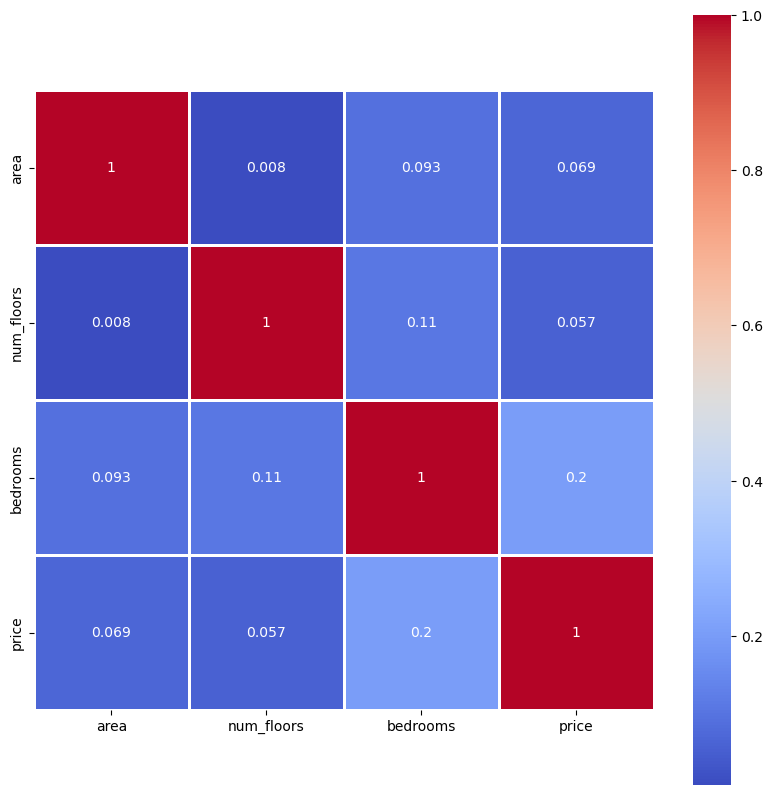

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(house_data.corr(), square=True ,annot=True, linewidths=1,cmap="coolwarm")

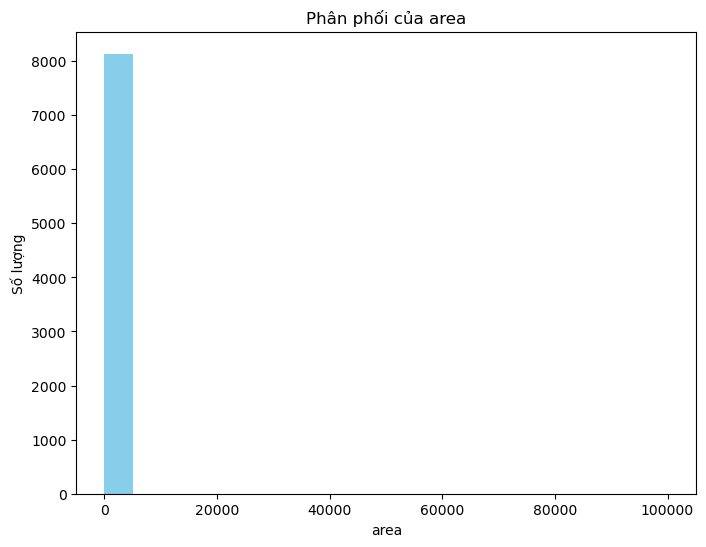

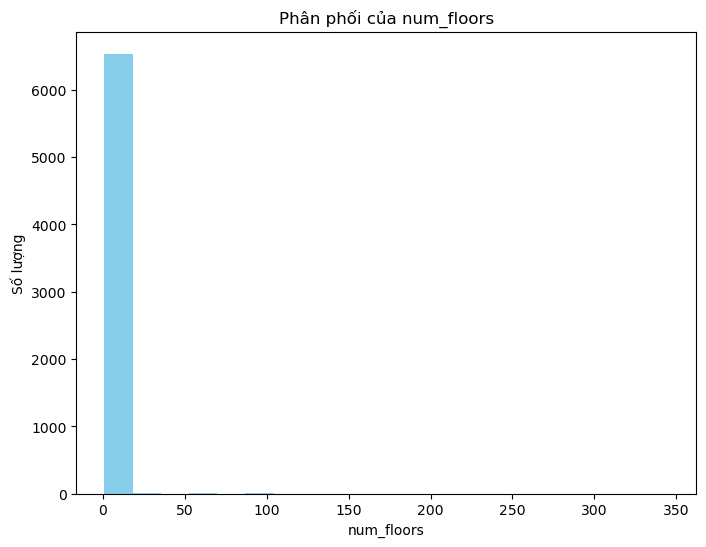

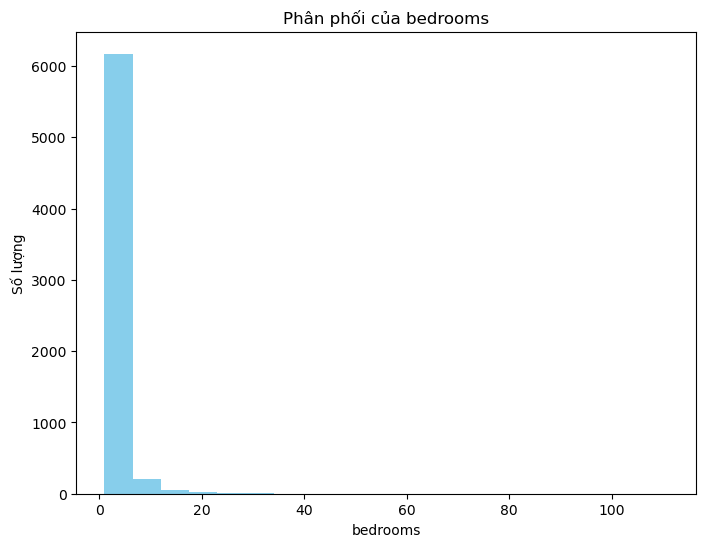

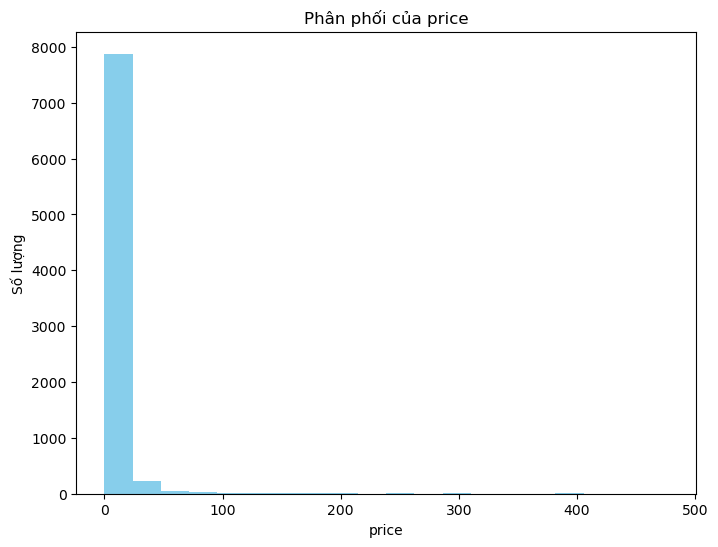

In [20]:

# Danh sách các feature cần xem phân phối
features = ['area','num_floors','bedrooms','price']

# Vẽ biểu đồ phân phối của các feature
for feature in features:
    plt.figure(figsize=(8, 6))
    plt.hist(house_data[feature], bins=20, color='skyblue')
    plt.xlabel(feature)
    plt.ylabel('Số lượng')
    plt.title('Phân phối của ' + feature)
    plt.show()

In [41]:
house_data['price'].fillna(0, inplace=True)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18968\17628545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_data['price'].fillna(0, inplace=True)


In [45]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='my_app')

# Tạo đối tượng geocoder
geocoder = geolocator.geocode

# Geocode the addresses to obtain latitude and longitude coordinates
locations = [geocoder(f"{district}, {city}") for district, city in zip(house_data['district'][0:100], house_data['city'][0:100])]

# Extract latitude and longitude coordinates from the locations
latitude = [location.latitude for location in locations]
longitude = [location.longitude for location in locations]

In [46]:
lat = 10.861410750000001
long = 106.66420925636413
zoom = 6
gmap2 = folium.Map(location=(lat, long), zoom_start=zoom)
def _addMarker(latitudes, longitudes,gmap):
    # Kiểm tra độ dài của danh sách latitude và longitude
    if len(latitudes) != len(longitudes):
        print("Danh sách latitude và longitude không cùng độ dài.")
        return
    # Thêm Marker vào map_obj
    for lat, lng in zip(latitudes, longitudes):
        marker = folium.Marker(location=(lat, lng))
        marker.add_to(gmap)
_addMarker(latitude,longitude,gmap2)
gmap2.save("foliumMarkerMultiple.html")

In [47]:
from folium.plugins import HeatMap

lat = 10.861410750000001
long = 106.66420925636413
zoom = 6
gmap2 = folium.Map(location=(lat, long), zoom_start=zoom)
maximum = max(house_data['price'])

def _addHeatMap(map_obj, latitudes, longitudes, values):
    # Tạo danh sách các tọa độ (latitude, longitude, value)
    data = list(zip(latitudes, longitudes, values))
    # Tạo HeatMap từ danh sách tọa độ và values
    heat_map = HeatMap(data)
    # Thêm HeatMap vào bản đồ
    map_obj.add_child(heat_map)
_addHeatMap(gmap2,latitude,longitude,house_data['price'][0:100])
gmap2.save("foliumHeatMap.html")